In [1]:
import h5py
import scipy.io as spio
import matplotlib.pyplot as plt
import numpy as np
from cmocean import cm as cmo
from scipy.interpolate import griddata
import scipy.integrate as integrate
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

#from matplotlib.mlab import griddata
import datetime as dt
import gsw
import scipy.interpolate as interp
from matplotlib.gridspec import GridSpec
#%%
plt.rcParams['text.usetex'] = True
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['font.size'] = 14
plt.rcParams['contour.negative_linestyle'] = 'solid'


In [2]:

#%% LOAD DYE DATA
#filename = '/home/jacob/dedalus/LATMIX/LatMix_2012/inj_data_2012'
#matfile = spio.loadmat(filename,struct_as_record=False, squeeze_me=True)
#matfile = spio.loadmat(filename,struct_as_record=True, squeeze_me=True)

filename = '/home/jacob/dedalus/LATMIX/LatMix_2012/my_triaxus_SI2'
filename = '/data/pacific/jacob/LATMIXDYE/LatMix_2012_Transfer/my_triaxus_SI2'
matfile = spio.loadmat(filename,struct_as_record=True, squeeze_me=True)


depth = matfile['DEPTH']
fluorppb = matfile['FLUORPPB']
shiplog = matfile['SHIPLOG']
rho = matfile['PDENS']
T = matfile['TEMP']
S = matfile['SALIN']
jday = matfile['JDAY']
lat = matfile['LAT']
lon = matfile['LON']
II = matfile['II'] # This indexes individual gulf stream crossings

fluorppb[np.isnan(fluorppb)] = 0
fluorppb[fluorppb<0] = 0
fluorppb[fluorppb==0] = 1e-10
nd, ns = shiplog.shape

#%% LOAD TIMESERIES DATA

jday_ts = matfile['jday_ts']
fluorppb_ts = matfile['fluorPPB_ts']
depth_ts = matfile['depth_ts']
lat_ts = matfile['lat_ts']
lon_ts = matfile['lon_ts']
rho_ts = matfile['pdens_ts']
T_ts = matfile['T_ts']
S_ts = matfile['S_ts']
    #%% LOAD FLOAT DATA
filename = '/home/jacob/dedalus/LATMIX/FloatData/Mar05_SI_2_Track.mat'
filename = '/data/pacific/jacob/LATMIXDYE/FloatData_Transfer/Mar05_SI_2_Track.mat'
matfile = spio.loadmat(filename,struct_as_record=False, squeeze_me=True)
floatstruct = matfile['F']
flat = floatstruct.lat
flon = floatstruct.lon
fyd = floatstruct.yd-1 #Craig convention

fyds = floatstruct.yds - 1
flats = floatstruct.lats
flons = floatstruct.lons

#sf = 10
#poly = np.polyfit(fyd,flat,6)
#flat_s = np.poly1d(poly)(fyd)
#
#window_size, poly_order = 51, 3
#flat_s = savgol_filter(flat, window_size, poly_order, deriv=0)
#flon_s = savgol_filter(flon, window_size, poly_order, deriv=0)
fvellat = np.gradient(flats)/np.gradient(fyds*86400)
fvellon = np.gradient(flons)/ np.gradient(fyds*86400)
fdir = np.arctan2(fvellat, fvellon)

filename = '/home/jacob/dedalus/LATMIX/FloatData/Env.mat'
filename = '/data/pacific/jacob/LATMIXDYE/FloatData_Transfer/Env.mat'

matfile = spio.loadmat(filename,struct_as_record=False, squeeze_me=True)
fT = matfile['T']
fS = matfile['S']
fT = np.mean(fT, axis=-1)# Top and bottom sensors
fS = np.mean(fS, axis=-1)
fydr = matfile['yd'] - 1
fP = matfile['P']


In [3]:
#%% Calculated depth integrated 
# Might be easier to do from gridded data

# NB. Need to figure out how to calculate across-stream distance for each cast, otherwise
# Nb. Also need to figure out how to interpolate/plot surface density for each of these.

# 1 ) At each point, calculate distance from float
# 2 ) Using instantaneous float velocity calculate cross-stream distance

fluor_int = np.zeros((ns,))
lat_int = np.zeros((ns,))
lon_int = np.zeros((ns,))
jday_int = np.zeros((ns,))
surf_rho = np.zeros((ns,))
shiplog_int = np.zeros((ns,))
zcom_rho = np.zeros((ns,))
zcom_t = np.zeros((ns,))
zcom_s = np.zeros((ns,))
zcom_si = np.zeros((ns,))
zcom_ti = np.zeros((ns,))
zcom_rhoi = np.zeros((ns,))
for i in range(0, ns):
    mask = np.isfinite(fluorppb[:,i])
    fluor_int[i] = integrate.trapz(fluorppb[mask,i], x=depth[mask,i])
    shiplog_int[i] = np.nanmean(shiplog[mask,i])
    lat_int[i] = np.nanmean(lat[:,i])
    lon_int[i] = np.nanmean(lon[:,i])
    jday_int[i] = np.nanmean(jday[:,i])
    ind = np.where(np.isfinite(rho[:,i]))[0][0]
    zcom = integrate.trapz(fluorppb[mask,i]*depth[mask,i], x=depth[mask,i])/fluor_int[i]
    surf_rho[i] = rho[ind,i]
    ind = np.argmin(np.abs(depth[:,i] - zcom))
    zcom_rho[i] = rho[ind,i]
    zcom_t[i] = T[ind,i]
    zcom_s[i] = S[ind,i]
    mask = np.logical_and(mask, np.isfinite(T[:,i]+S[:,i]))
    zcom_ti[i] = integrate.trapz(fluorppb[mask,i]*T[mask,i], x=depth[mask,i])/fluor_int[i]
    zcom_si[i] = integrate.trapz(fluorppb[mask,i]*S[mask,i], x=depth[mask,i])/fluor_int[i]
    zcom_rhoi[i] = integrate.trapz(fluorppb[mask,i]*rho[mask,i], x=depth[mask,i])/fluor_int[i]


# calc distance relative to float
iflat = np.interp(jday_int, fyds, flats)
iflon = np.interp(jday_int, fyds, flons)
distlat = (lat_int-iflat)*111e3*np.cos(lat_int)
distlon = (lon_int-iflon)*111e3

fdist = np.sign(lat_int-iflat)*np.sqrt(((lat_int - iflat)*111e3*np.cos(lat_int))**2 + ((lon_int - iflon)*111e3)**2)

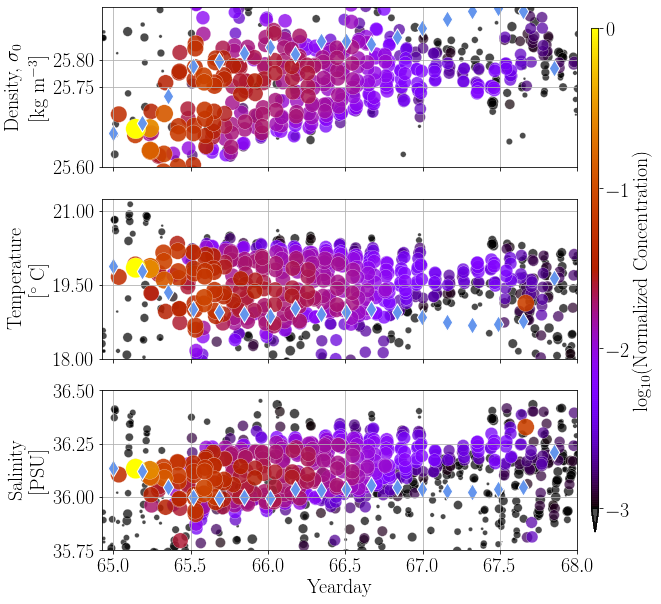

In [39]:
#%% 3 Panel Surface MANUSCRIPT
plt.rcParams['text.usetex'] = True
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['font.size'] = 20
plt.rcParams['contour.negative_linestyle'] = 'solid'
from matplotlib.ticker import FormatStrFormatter

cmap = 'gnuplot'
cl = [-5, -1]
norm = np.max(fluorppb_ts)
mask = (fluorppb_ts/norm>10**(cl[0])) & (jday_ts<68)
#mask = jday_ts<90
xedges = np.linspace(34.5, 37, 150)
yedges = np.linspace(13, 22, 150)
X, Y = np.meshgrid(xedges, yedges)
SA = gsw.SA_from_SP(X, 0, -66, 39)
CT = gsw.CT_from_t(SA, Y, 0)
R = gsw.rho(SA, CT, 0)
R = R - 1000
si = np.argmin(np.abs(fydr-65))
ei = np.argmin(np.abs(fydr-68))
dstep = (fydr[-1] - fydr[0])/fydr.size
span = int(1/6/dstep)

lims = range(si, ei, span)
SA = gsw.SA_from_SP(fS, fP, -66, 39)
CT = gsw.CT_from_t(SA, fT, fP)
Rf = gsw.rho(SA, CT, 0)
Rf = Rf - 1000
norm = np.sum(fluorppb_ts[mask])
norm = 1
H, xedges, yedges = np.histogram2d(S_ts[mask], T_ts[mask], weights=(fluorppb_ts[mask]/norm),   bins=(xedges, yedges), density=False)

# Get the colormap colors
cmap = plt.cm.gnuplot
my_cmap = cmap(np.arange(cmap.N))

# Set alpha
my_cmap[:,-1] = np.linspace(0.7, 1, cmap.N)

# Create new colormap
from matplotlib.colors import ListedColormap
my_cmap = ListedColormap(my_cmap)

#fig = plt.figure(figsize=(12.78, 9.41))
fig, ax = plt.subplots(3,1, sharex=True, figsize=(8, 10))
normscatter=np.max(fluor_int)
mask = fluor_int/normscatter>1e-4

x = jday_int[mask]
z = (fluor_int[mask]/normscatter)
yt =[]
yt.append(zcom_rhoi[mask])
yt.append(zcom_ti[mask])
yt.append(zcom_si[mask])
fYt = []
fYt.append(Rf[lims])
fYt.append(fT[lims])
fYt.append(fS[lims])
ylims = []
ylims.append([25.6, 25.9])
#ylims.append([25.72, 25.82])

ylims.append([18, 21.25])
ylims.append([35.75, 36.5])
yticks = []
yticks.append([25.6, 25.75, 25.8])
#yticks.append([25.5, 25.6, 25.7, 25.8])

yticks.append([18, 19.5 ,21])
yticks.append([35.75, 36, 36.25, 36.5])
titles =[]
titles.append('Density, $\sigma_0$\n [kg m$^{-3}$]')
titles.append('Temperature\n [$^{\circ}$ C]')
titles.append('Salinity\n [PSU]')
cl=[-3, 0]
for i in range (0, 3):
    #axsurf = plt.subplot2grid((3,4), (i,0), rowspan=1, colspan=4)
    axsurf = ax[i]
    axsurf.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    normscatter = np.nanmax(fluor_int)
    axsurf.grid()
    y = yt[i]
    x = jday_int[mask]
    c = np.log10(fluor_int[mask]/normscatter)
    s = 1e2*np.log10(1e4*fluor_int[mask]/normscatter)
    sortinds = np.argsort(c)
    c = c[sortinds]; s = s[sortinds]; x = x[sortinds]; y=y[sortinds]
    ix = axsurf.scatter(x, y, c=c,s=s, edgecolor='w',linewidth=0.25, cmap=my_cmap, vmin=cl[0], vmax=cl[1])
    axsurf.scatter(fydr[lims], fYt[i], marker='d', color='cornflowerblue', edgecolor='w', s=150)
    axsurf.set_ylabel(titles[i])
    axsurf.set_xlim(64.925, 67.5)
    #axsurf.set_xlim(65.1, 65.8)
    axsurf.set_ylim(ylims[i][0], ylims[i][-1])
    axsurf.set_yticks(yticks[i])
#axsurf.annotate("", xy=(65.14, yticks[i][0]), xytext=(65.14, yticks[i][0]*0.9965),arrowprops=dict(arrowstyle="->"))
#axsurf.annotate("", xy=(65.24, yticks[i][0]), xytext=(65.24, yticks[i][0]*0.9965),arrowprops=dict(arrowstyle="->"))
#axsurf.annotate("", xy=(65.33, yticks[i][0]), xytext=(65.33, yticks[i][0]*0.9965),arrowprops=dict(arrowstyle="->"))
#axsurf.annotate("", xy=(65.53, yticks[i][0]), xytext=(65.53, yticks[i][0]*0.9965),arrowprops=dict(arrowstyle="->"))

axsurf.set_xlabel('Yearday')
fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.975, 0.15, 0.0125, 0.7])
cb = fig.colorbar(ix, cax=cbar_ax, extend='min')
cb.set_label('log$_{10}$(Normalized Concentration)')
cb.set_ticks([-3, -2, -1, 0])
cb.solids.set_edgecolor("face") 

plt.subplots_adjust(hspace=0.2)

#plt.savefig('/data/pacific/jacob/LATMIXDYE/NEWFIGS/DyeDensity_2.pdf', bbox_inches='tight')


In [48]:
fydr.shape

(11200,)

/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in log10
/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in log10
/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in log10


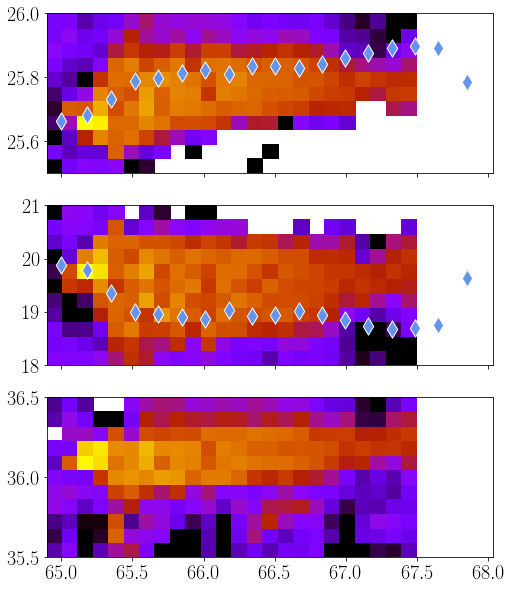

In [52]:
#%% 3 Panel Surface HISTOGRAM
plt.rcParams['text.usetex'] = True
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['font.size'] = 20
plt.rcParams['contour.negative_linestyle'] = 'solid'
from matplotlib.ticker import FormatStrFormatter

nx = 25
ny = 12

cmap = 'gnuplot'
cl = [-5, -1]
norm = np.max(fluorppb_ts)
mask = (fluorppb_ts/norm>10**(cl[0])) & (jday_ts<68) & (np.isfinite(rho_ts))
#mask = jday_ts<90
xedges = np.linspace(34.5, 37, 150)
yedges = np.linspace(13, 22, 150)
X, Y = np.meshgrid(xedges, yedges)
SA = gsw.SA_from_SP(X, 0, -66, 39)
CT = gsw.CT_from_t(SA, Y, 0)
R = gsw.rho(SA, CT, 0)
R = R - 1000
si = np.argmin(np.abs(fydr-65))
ei = np.argmin(np.abs(fydr-68))
dstep = (fydr[-1] - fydr[0])/fydr.size
span = int(1/6/dstep)

lims = range(si, ei, span)
SA = gsw.SA_from_SP(fS, fP, -66, 39)
CT = gsw.CT_from_t(SA, fT, fP)
Rf = gsw.rho(SA, CT, 0)
Rf = Rf - 1000
norm = np.sum(fluorppb_ts[mask])
norm = 1
xedges = np.linspace(64.9, 67.5, nx)
yedges = np.linspace(25.5, 26, ny)
H, xedges, yedges = np.histogram2d(jday_ts[mask], rho_ts[mask], weights=(fluorppb_ts[mask]/norm),   bins=(xedges, yedges), density=False)

# Get the colormap colors
cmap = plt.cm.gnuplot

fig, ax = plt.subplots(3,1, sharex=True, figsize=(8, 10))
axrho = ax[0]
ix = axrho.pcolor( xedges, yedges, np.transpose(np.log10(H/np.nansum(H))), vmin=cl[0], vmax=cl[1], cmap=cmap)
axrho.scatter(fydr[lims], Rf[lims], marker='d', color='cornflowerblue', edgecolor='w', s=150)

axtemp = ax[1]
yedges = np.linspace(18, 21, ny)
H, xedges, yedges = np.histogram2d(jday_ts[mask], T_ts[mask], weights=(fluorppb_ts[mask]/norm),   bins=(xedges, yedges), density=False)
ix = axtemp.pcolor( xedges, yedges, np.transpose(np.log10(H/np.nansum(H))), vmin=cl[0], vmax=cl[1], cmap=cmap)
axtemp.scatter(fydr[lims], fT[lims], marker='d', color='cornflowerblue', edgecolor='w', s=150)

axsal = ax[2]
yedges = np.linspace(35.5, 36.5, ny)
H, xedges, yedges = np.histogram2d(jday_ts[mask], S_ts[mask], weights=(fluorppb_ts[mask]/norm),   bins=(xedges, yedges), density=False)
ix = axsal.pcolor( xedges, yedges, np.transpose(np.log10(H/np.nansum(H))), vmin=cl[0], vmax=cl[1], cmap=cmap)


<IPython.core.display.Javascript object>


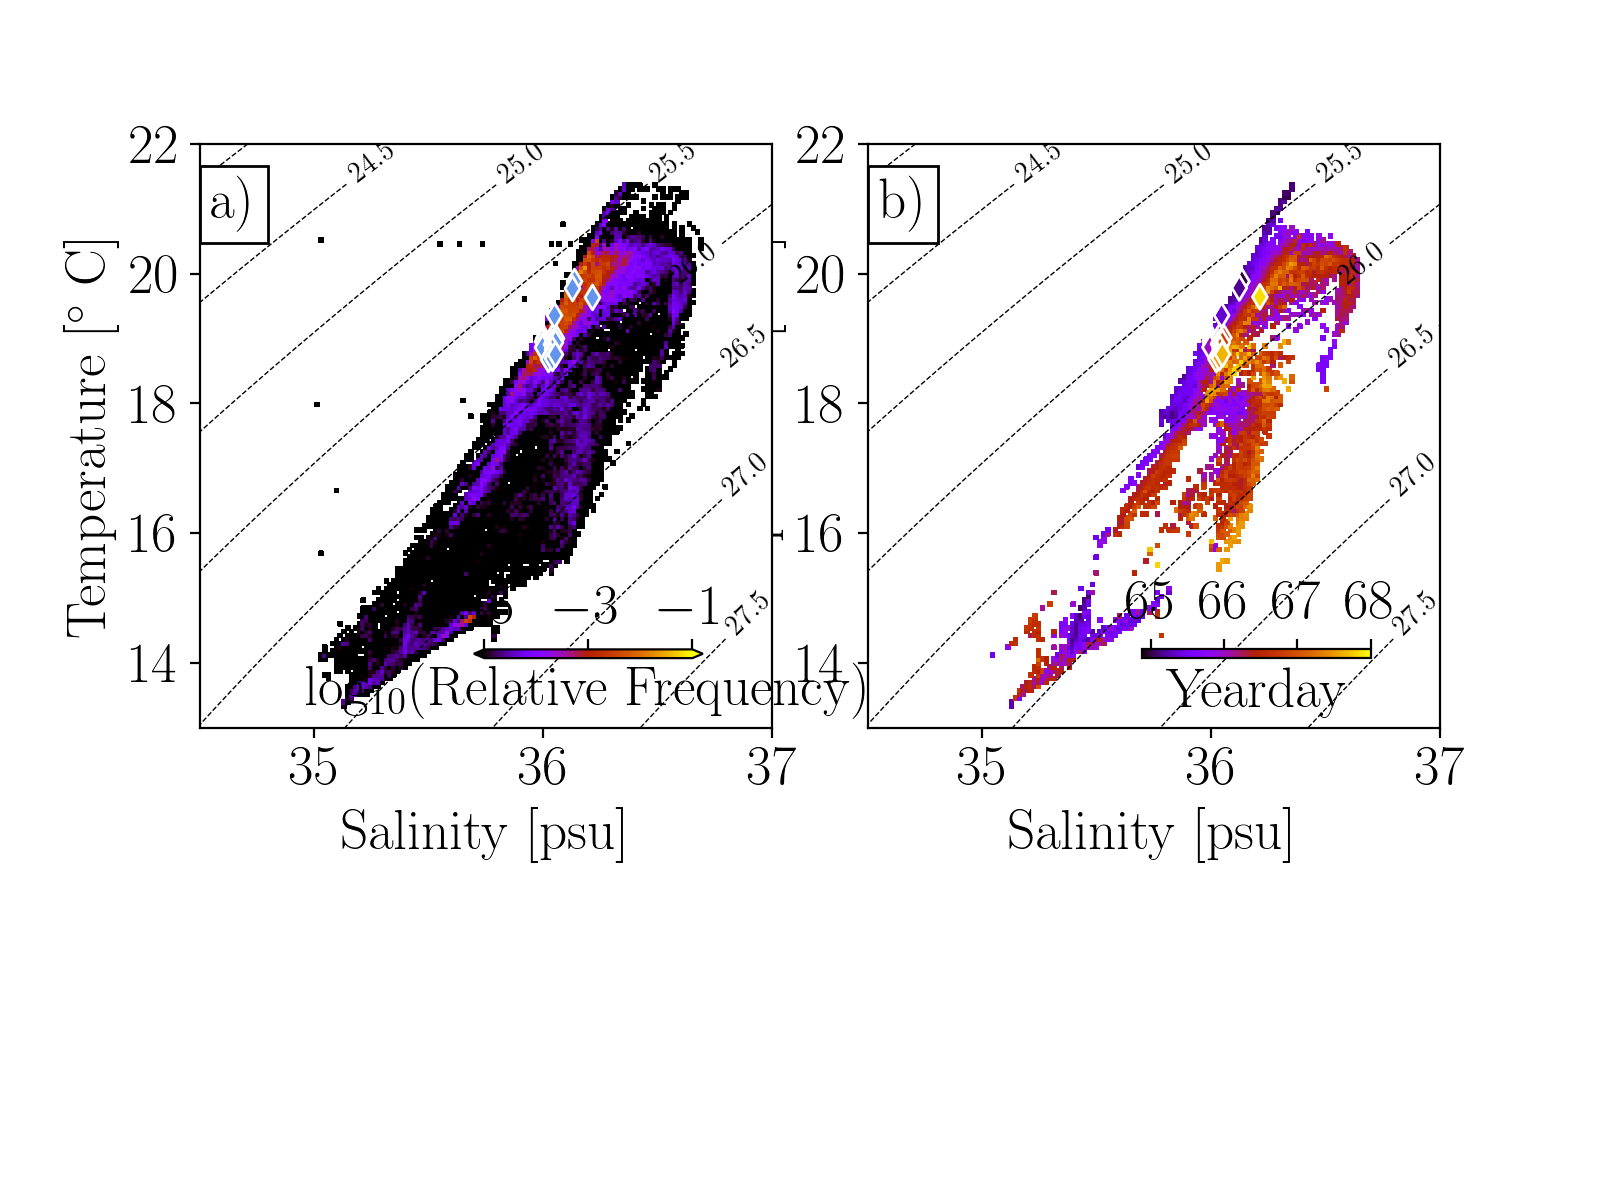

/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in log10
/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in log10


In [80]:
#%% HISTO IN T-S Space 3 panel 

cmap = 'gnuplot'
cl = [-5, -1]
norm = np.max(fluorppb_ts)
mask = (fluorppb_ts/norm>10**(cl[0])) & (jday_ts<68)
#mask = jday_ts<90
xedges = np.linspace(34.5, 37, 150)
yedges = np.linspace(13, 22, 150)
X, Y = np.meshgrid(xedges, yedges)
SA = gsw.SA_from_SP(X, 0, -66, 39)
CT = gsw.CT_from_t(SA, Y, 0)
R = gsw.rho(SA, CT, 0)
R = R - 1000

SA = gsw.SA_from_SP(fS, fP, -66, 39)
CT = gsw.CT_from_t(SA, fT, fP)
Rf = gsw.rho(SA, CT, 0)
Rf = Rf - 1000
norm = np.sum(fluorppb_ts[mask])
norm = 1
H, xedges, yedges = np.histogram2d(S_ts[mask], T_ts[mask], weights=(fluorppb_ts[mask]/norm),   bins=(xedges, yedges), density=False)
#fig = plt.figure(figsize=(12.78, 9.41))

fig = plt.figure(figsize=(8, 6))

# TIME-PLOT
axhistot = plt.subplot2grid((3,4), (0,2), rowspan = 2, colspan=2)

Htime, xedges, yedges = np.histogram2d(S_ts[mask], T_ts[mask], weights=(fluorppb_ts[mask]*jday_ts[mask]),   bins=(xedges, yedges), density=False)
Hcount, xedges, yedges = np.histogram2d(S_ts[mask], T_ts[mask],   bins=(xedges, yedges), density=False)
Hf, xedges, yedges = np.histogram2d(S_ts[mask], T_ts[mask],  weights=(fluorppb_ts[mask]), bins=(xedges, yedges), density=False)

Havgtime = Htime/(Hf) # This is the concentration weighted average time

mask = ((np.log10(H/np.sum(H)))>-5)
Havgtime[~mask] = np.nan
#Havgtime = Htime/Hcount
cmapt = 'gnuplot'
ix = axhistot.pcolor( xedges, yedges, np.transpose(Havgtime),  cmap=cmapt, vmin=64.87, vmax=68)
ix.set_edgecolor('face')
#axhisto.grid()
conts = np.linspace(20, 30, 21)
CL = axhistot.contour(X, Y, R,conts, colors='k', linestyles='dashed', linewidths=0.5)
axhistot.clabel(CL, inline=1, fontsize=10, fmt='%1.1f')
axhistot.set_xlabel('Salinity [psu]')
axhistot.set_ylabel('Temperature [$^\circ$ C]')
si = np.argmin(np.abs(fydr-65))
ei = np.argmin(np.abs(fydr-68))
dstep = (fydr[-1] - fydr[0])/fydr.size
span = int(1/6/dstep)
lims = range(si, ei, span)
axhistot.scatter(fS[lims], fT[lims], c = fydr[lims], marker='d', edgecolor='w', s=40, cmap=cmapt, vmin=64.87, vmax=68)
axhistot.text(34.55, 20.85 ,'b)', color='k', size=20, bbox=dict(facecolor='w', edgecolor='k'))

cbaxes = inset_axes(axhistot, width="40%", height="1.5%", loc=4, borderpad=1.25) 

cb = plt.colorbar(ix,cax=cbaxes,orientation='horizontal',)
cb.ax.xaxis.set_ticks_position('top')
cb.set_ticks([65, 66, 67, 68])
#cb = plt.colorbar(ix, extend='both')
cb.set_label('Yearday')

# COLORED HISTOGRAM
axhisto = plt.subplot2grid((3,4), (0,0), rowspan = 2, colspan=2)
ix = axhisto.pcolor( xedges, yedges, np.transpose(np.log10(H/np.sum(H))), vmin=cl[0], vmax=cl[1], cmap=cmap)
ix.set_edgecolor('face')
conts = np.linspace(20, 30, 21)
CL = axhisto.contour(X, Y, R,conts, colors='k', linestyles='dashed', linewidths=0.5)

axhisto.clabel(CL, inline=1, fontsize=10, fmt='%1.1f')
axhisto.set_xlabel('Salinity [psu]')
axhisto.set_ylabel('Temperature [$^\circ$ C]')
#si = np.argmin(np.abs(fydr-65))
#dstep = (fydr[-1] - fydr[0])/fydr.size
#span = int(1/6/dstep)
#lims = range(si, fydr.size, span)
axhisto.scatter(fS[lims], fT[lims], marker='d', color='cornflowerblue', edgecolor='w', s=40)
axhisto.text(34.55, 20.85 ,'a)', color='k', size=20, bbox=dict(facecolor='w', edgecolor='k'))

#cbaxes = inset_axes(axhisto, width="1%", height="60%", loc=6) 
#cb = plt.colorbar(ix, cax=cbaxes, extend='both')
cbaxes = inset_axes(axhisto, width="40%", height="1.5%", loc=4, borderpad=1.25) 

cb = plt.colorbar(ix,cax=cbaxes,orientation='horizontal', extend='both')
cb.ax.xaxis.set_ticks_position('top')
cb.set_ticks([-5,  -3,  -1])
#cb = plt.colorbar(ix, extend='both')
cb.set_label('log$_{10}$(Relative Frequency)')



cb.ax.xaxis.set_ticks_position('top')
plt.subplots_adjust(wspace=0.4, hspace=0.4)

#axs['5'].contour(jd, sd, grid_surf_rho, 5)
#axs['5'].set_xlim([64.75, 67])
#axsurf.set_ylim(-10, 10)
#plt.scatter(S_ts[mask], T_ts[mask], c=np.log10(fluorppb_ts[mask]/norm), s=1)

#plt.savefig('/home/jacob/Dropbox/GulfStreamDye/LATMIXSCIENCE/DyeDensity.pdf', bbox_inches='tight')

In [24]:
H

array([[0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [ ]:
my_cmap = cmap(np.arange(cmap.N))

# Set alpha
my_cmap[:,-1] = np.linspace(0.7, 1, cmap.N)

# Create new colormap
from matplotlib.colors import ListedColormap
my_cmap = ListedColormap(my_cmap)

#fig = plt.figure(figsize=(12.78, 9.41))
fig, ax = plt.subplots(3,1, sharex=True, figsize=(8, 10))
normscatter=np.max(fluor_int)
mask = fluor_int/normscatter>1e-4

x = jday_int[mask]
z = (fluor_int[mask]/normscatter)
yt =[]
yt.append(zcom_rhoi[mask])
yt.append(zcom_ti[mask])
yt.append(zcom_si[mask])
fYt = []
fYt.append(Rf[lims])
fYt.append(fT[lims])
fYt.append(fS[lims])
ylims = []
ylims.append([25.6, 25.9])
#ylims.append([25.72, 25.82])

ylims.append([18, 21.25])
ylims.append([35.75, 36.5])
yticks = []
yticks.append([25.6, 25.75, 25.8])
#yticks.append([25.5, 25.6, 25.7, 25.8])

yticks.append([18, 19.5 ,21])
yticks.append([35.75, 36, 36.25, 36.5])
titles =[]
titles.append('Density, $\sigma_0$\n [kg m$^{-3}$]')
titles.append('Temperature\n [$^{\circ}$ C]')
titles.append('Salinity\n [PSU]')
cl=[-3, 0]
for i in range (0, 3):
    #axsurf = plt.subplot2grid((3,4), (i,0), rowspan=1, colspan=4)
    axsurf = ax[i]
    axsurf.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    normscatter = np.nanmax(fluor_int)
    axsurf.grid()
    y = yt[i]
    x = jday_int[mask]
    c = np.log10(fluor_int[mask]/normscatter)
    s = 1e2*np.log10(1e4*fluor_int[mask]/normscatter)
    sortinds = np.argsort(c)
    c = c[sortinds]; s = s[sortinds]; x = x[sortinds]; y=y[sortinds]
    ix = axsurf.scatter(x, y, c=c,s=s, edgecolor='w',linewidth=0.25, cmap=my_cmap, vmin=cl[0], vmax=cl[1])
    axsurf.scatter(fydr[lims], fYt[i], marker='d', color='cornflowerblue', edgecolor='w', s=150)
    axsurf.set_ylabel(titles[i])
    axsurf.set_xlim(64.925, 67.5)
    #axsurf.set_xlim(65.1, 65.8)
    axsurf.set_ylim(ylims[i][0], ylims[i][-1])
    axsurf.set_yticks(yticks[i])
#axsurf.annotate("", xy=(65.14, yticks[i][0]), xytext=(65.14, yticks[i][0]*0.9965),arrowprops=dict(arrowstyle="->"))
#axsurf.annotate("", xy=(65.24, yticks[i][0]), xytext=(65.24, yticks[i][0]*0.9965),arrowprops=dict(arrowstyle="->"))
#axsurf.annotate("", xy=(65.33, yticks[i][0]), xytext=(65.33, yticks[i][0]*0.9965),arrowprops=dict(arrowstyle="->"))
#axsurf.annotate("", xy=(65.53, yticks[i][0]), xytext=(65.53, yticks[i][0]*0.9965),arrowprops=dict(arrowstyle="->"))

axsurf.set_xlabel('Yearday')
fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.975, 0.15, 0.0125, 0.7])
cb = fig.colorbar(ix, cax=cbar_ax, extend='min')
cb.set_label('log$_{10}$(Normalized Concentration)')
cb.set_ticks([-3, -2, -1, 0])
cb.solids.set_edgecolor("face") 

plt.subplots_adjust(hspace=0.2)

#plt.savefig('/data/pacific/jacob/LATMIXDYE/NEWFIGS/DyeDensity_2.pdf', bbox_inches='tight')

<IPython.core.display.Javascript object>


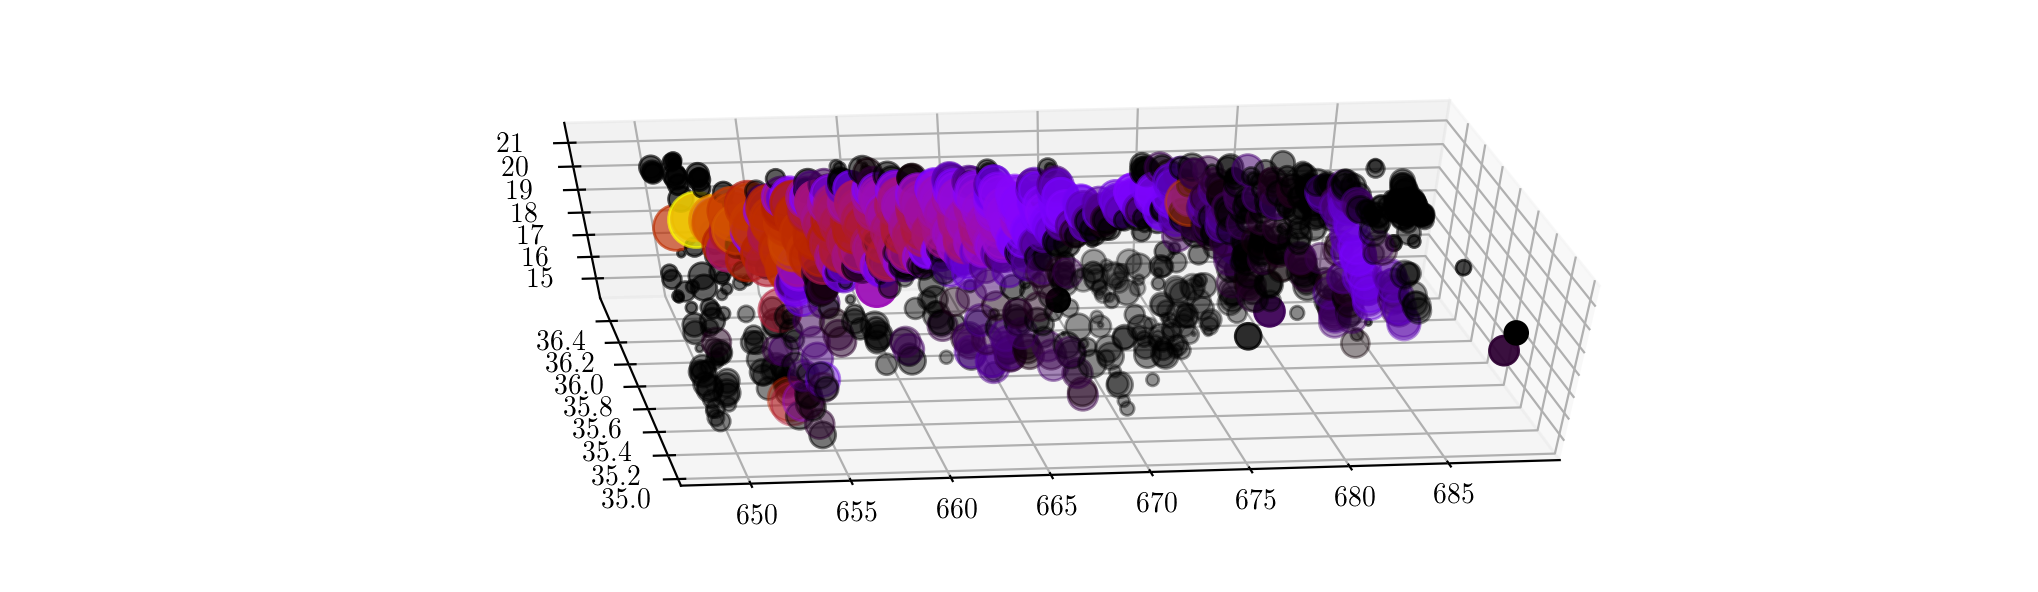

In [63]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D



fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111, projection='3d')

mask = (fluor_int/normscatter>1e-4) & (zcom_si>35)



ax.scatter(jday_int[mask]*10, zcom_si[mask], zcom_ti[mask],c=np.log10(fluor_int[mask]/normscatter), s=1e2*np.log10(1e4*fluor_int[mask]/normscatter), marker='o',
           cmap=cmap, vmin=-3, vmax=0)

#ax.auto_scale_xyz([64, 100], [35, 36.5], [15, 21])

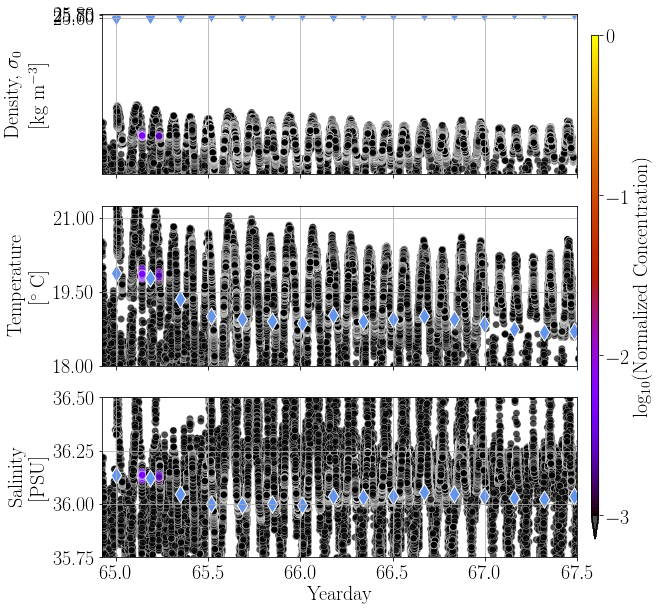

In [20]:
#%% 3 Panel Surface 
plt.rcParams['text.usetex'] = True
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['font.size'] = 20
plt.rcParams['contour.negative_linestyle'] = 'solid'
from matplotlib.ticker import FormatStrFormatter

cmap = 'gnuplot'
cl = [-5, -1]
norm = np.max(fluorppb_ts)
mask = (fluorppb_ts/norm>10**(cl[0])) & (jday_ts<68)
#mask = jday_ts<90
xedges = np.linspace(34.5, 37, 150)
yedges = np.linspace(13, 22, 150)
X, Y = np.meshgrid(xedges, yedges)
SA = gsw.SA_from_SP(X, 0, -66, 39)
CT = gsw.CT_from_t(SA, Y, 0)
R = gsw.rho(SA, CT, 0)
R = R - 1000
si = np.argmin(np.abs(fydr-65))
ei = np.argmin(np.abs(fydr-68))
dstep = (fydr[-1] - fydr[0])/fydr.size
span = int(1/6/dstep)

lims = range(si, ei, span)
SA = gsw.SA_from_SP(fS, fP, -66, 39)
CT = gsw.CT_from_t(SA, fT, fP)
Rf = gsw.rho(SA, CT, 0)
Rf = Rf - 1000
norm = np.sum(fluorppb_ts[mask])
norm = 1
H, xedges, yedges = np.histogram2d(S_ts[mask], T_ts[mask], weights=(fluorppb_ts[mask]/norm),   bins=(xedges, yedges), density=False)

# Get the colormap colors
cmap = plt.cm.gnuplot
my_cmap = cmap(np.arange(cmap.N))

# Set alpha
my_cmap[:,-1] = np.linspace(0.7, 1, cmap.N)

# Create new colormap
from matplotlib.colors import ListedColormap
my_cmap = ListedColormap(my_cmap)

#fig = plt.figure(figsize=(12.78, 9.41))
fig, ax = plt.subplots(3,1, sharex=True, figsize=(8, 10))
normscatter=np.max(fluor_int)
#mask = fluor_int/normscatter>1e-4
norm = np.sum(fluorppb_ts[mask])

x = jday_ts[mask]
z = (fluorppb_ts[mask]/norm)
yt =[]
yt.append(T_ts[mask])
yt.append(T_ts[mask])
yt.append(S_ts[mask])
fYt = []
fYt.append(Rf[lims])
fYt.append(fT[lims])
fYt.append(fS[lims])
ylims = []
#ylims.append([25.6, 25.9])
#ylims.append([25.72, 25.82])
ylims.append([18, 21.25])

ylims.append([18, 21.25])
ylims.append([35.75, 36.5])
yticks = []
yticks.append([25.6, 25.75, 25.8])
#yticks.append([25.5, 25.6, 25.7, 25.8])

yticks.append([18, 19.5 ,21])
yticks.append([35.75, 36, 36.25, 36.5])
titles =[]
titles.append('Density, $\sigma_0$\n [kg m$^{-3}$]')
titles.append('Temperature\n [$^{\circ}$ C]')
titles.append('Salinity\n [PSU]')
cl=[-3, 0]
for i in range (0, 3):
    #axsurf = plt.subplot2grid((3,4), (i,0), rowspan=1, colspan=4)
    axsurf = ax[i]
    axsurf.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    normscatter = np.nanmax(fluor_int)
    axsurf.grid()
    y = yt[i]
    x = jday_ts[mask]
    c = np.log10(z)
    s = 1e4*np.log10(1e4*z)
    s = 50 + 0*s
    sortinds = np.argsort(c)
    c = c[sortinds]; s = s[sortinds]; x = x[sortinds]; y=y[sortinds]
    ix = axsurf.scatter(x, y, c=c,s=s, edgecolor='w',linewidth=0.25, cmap=my_cmap, vmin=cl[0], vmax=cl[1])
    axsurf.scatter(fydr[lims], fYt[i], marker='d', color='cornflowerblue', edgecolor='w', s=150)
    axsurf.set_ylabel(titles[i])
    axsurf.set_xlim(64.925, 67.5)
    #axsurf.set_xlim(65.1, 65.8)
    axsurf.set_ylim(ylims[i][0], ylims[i][-1])
    axsurf.set_yticks(yticks[i])
#axsurf.annotate("", xy=(65.14, yticks[i][0]), xytext=(65.14, yticks[i][0]*0.9965),arrowprops=dict(arrowstyle="->"))
#axsurf.annotate("", xy=(65.24, yticks[i][0]), xytext=(65.24, yticks[i][0]*0.9965),arrowprops=dict(arrowstyle="->"))
#axsurf.annotate("", xy=(65.33, yticks[i][0]), xytext=(65.33, yticks[i][0]*0.9965),arrowprops=dict(arrowstyle="->"))
#axsurf.annotate("", xy=(65.53, yticks[i][0]), xytext=(65.53, yticks[i][0]*0.9965),arrowprops=dict(arrowstyle="->"))

axsurf.set_xlabel('Yearday')
fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.975, 0.15, 0.0125, 0.7])
cb = fig.colorbar(ix, cax=cbar_ax, extend='min')
cb.set_label('log$_{10}$(Normalized Concentration)')
cb.set_ticks([-3, -2, -1, 0])
cb.solids.set_edgecolor("face") 

plt.subplots_adjust(hspace=0.2)

#plt.savefig('/data/pacific/jacob/LATMIXDYE/NEWFIGS/DyeDensity_2.pdf', bbox_inches='tight')


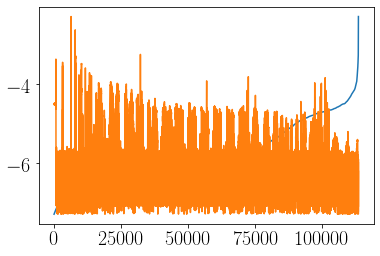

In [17]:
plt.plot(c)
plt.plot(np.log10(z))